# Este notebook crea el modelo NB que usaremos en app.py para detectar spam en español 
modelo_naive_bayes_entrenado_completo.pkl y el vectorizador.pkl que usaremos para tratar los textos antes del modelo.
Estamos usando un modelo Naive Bayes entrenado con todo el dataset de train.csv (train + validación)

## Entrenamos el modelo Naive Bayes con todo el dataset

1: Cargar los datos y vista preliminar
Voy a cargar el archivo train.csv y mostrar las primeras filas para entender mejor la estructura del dataset.

In [1]:
# Importar las librerías necesarias
import pandas as pd

# Cargar el archivo CSV
train_df = pd.read_csv('../data_es/train.csv')

# Mostrar las primeras filas del dataset
print(train_df.head(20))

                                              mensaje  tipo
0         Compra ahora y recibe un descuento especial   ham
1                  Haz clic aqui para ganar un premio  spam
2                         Tu ordenador tiene un virus  spam
3               Descubre como perder peso rapidamente  spam
4                        Necesitas ayuda con tu tarea   ham
5                 Gana dinero desde casa sin esfuerzo  spam
6           Reclama tu herencia de un pariente lejano  spam
7      Mejora tu rendimiento sexual con este producto  spam
8                  Por favor responde a esta encuesta   ham
9     Invierte en esta oportunidad unica y hazte rico  spam
10               Comparte este mensaje con tus amigos   ham
11  Obten un prestamo facilmente sin verificacion ...  spam
12           Felicidades has ganado un telefono nuevo  spam
13           Necesitamos verificar tu cuenta bancaria  spam
14                     Aprende ingles en solo 10 dias  spam
15                              Gracias 

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   mensaje  998 non-null    object
 1    tipo    998 non-null    object
dtypes: object(2)
memory usage: 15.7+ KB


2. Resumen estadístico

In [3]:
# Resumen estadístico del dataset
print(train_df.describe())

# Resumen de las columnas no numéricas
print(train_df.describe(include=['O']))

                                mensaje  tipo
count                               998   998
unique                              850     2
top     Asiste a la charla motivacional  spam
freq                                  2   521
                                mensaje  tipo
count                               998   998
unique                              850     2
top     Asiste a la charla motivacional  spam
freq                                  2   521


3. Distribución de las etiquetas
Analizaremos la distribución de las etiquetas "spam" y "ham" y visualizaremos esta distribución.



In [4]:
# Mostrar los nombres de las columnas del dataset
print(train_df.columns)


Index(['mensaje', ' tipo'], dtype='object')


In [5]:
# Renombrar la columna ' tipo' a 'tipo' usando .rename()
train_df = train_df.rename(columns={' tipo': 'tipo'})

# Verificar que el cambio se haya realizado correctamente
print(train_df.columns)


Index(['mensaje', 'tipo'], dtype='object')


tipo
spam    521
ham     477
Name: count, dtype: int64


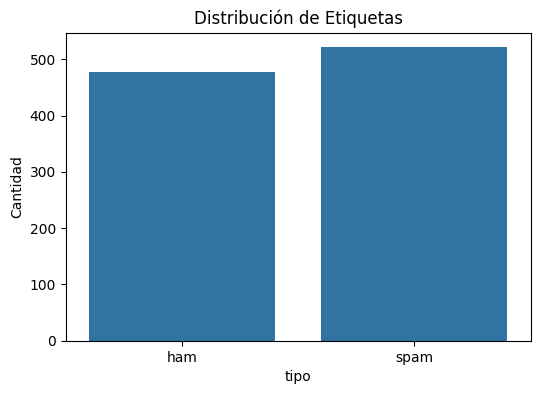

In [6]:
# Contar la cantidad de mensajes en cada categoría
label_counts = train_df['tipo'].value_counts()

# Mostrar la distribución de etiquetas
print(label_counts)

# Visualización de la distribución de etiquetas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='tipo', data=train_df)
plt.title('Distribución de Etiquetas')
plt.xlabel('tipo')
plt.ylabel('Cantidad')
plt.show()


Resumen de los Datos

Resumen de la Distribución de Etiquetas (tipo):

spam: 521 mensajes
ham (legítimo): 477 mensajes
Resumen de los Mensajes:

Total de mensajes: 998
Mensajes únicos: 850
Mensaje más frecuente: "Asiste a la charla motivacional" con frecuencia de 2 veces.

Información del DataFrame:

Hay dos columnas en tu DataFrame: mensaje y tipo.
El DataFrame tiene 998 entradas (filas).
Ambas columnas (mensaje y tipo) contienen datos de tipo object.

In [7]:
# Encontrar mensajes repetidos
mensajes_repetidos = train_df[train_df.duplicated(subset='mensaje', keep=False)]

# Mostrar los mensajes repetidos
print(f"Total de mensajes repetidos: {mensajes_repetidos.shape[0]}")
print(mensajes_repetidos)

# Opcionalmente, mostrar algunos detalles de los mensajes repetidos
print("\nEjemplos de mensajes repetidos:")
print(mensajes_repetidos.head())


Total de mensajes repetidos: 296
                                               mensaje  tipo
154         Te recordamos que tienes un pago pendiente  spam
228             Hola soy tu asesor financiero personal  spam
239  Confirma tu suscripción a nuestra lista de cor...  spam
404         Te recordamos que tienes un pago pendiente   ham
474  Confirma tu suscripción a nuestra lista de cor...  spam
..                                                 ...   ...
993             Sorprende a tu pareja con este perfume  spam
994                 Resolveremos tu caso a la brevedad   ham
995             Invierte en bienes raíces con expertos  spam
996               Hola evaluemos tu perfil profesional   ham
997            Ahorra en grande con nuestra cuenta VIP  spam

[296 rows x 2 columns]

Ejemplos de mensajes repetidos:
                                               mensaje  tipo
154         Te recordamos que tienes un pago pendiente  spam
228             Hola soy tu asesor financiero personal  

In [8]:
# Filtramos estos mensajes para aquellos que tienen tanto etiqueta spam como ham
mensajes_repetidos_spam_y_ham = mensajes_repetidos.groupby('mensaje')['tipo'].apply(set)
mensajes_repetidos_spam_y_ham = mensajes_repetidos_spam_y_ham[mensajes_repetidos_spam_y_ham.apply(lambda x: len(x) > 1)]

# Mostrar los mensajes repetidos que aparecen como spam y como ham
print("Mensajes que aparecen como spam y como ham a la vez:")
for mensaje in mensajes_repetidos_spam_y_ham.index:
    print(f"Mensaje: {mensaje}")
    print(f"Tipos: {', '.join(mensajes_repetidos_spam_y_ham[mensaje])}")
    print()


Mensajes que aparecen como spam y como ham a la vez:
Mensaje: Te recordamos que tienes un pago pendiente
Tipos: ham, spam



In [9]:
# Identificar el mensaje y tipo específico que deseas eliminar
mensaje_a_eliminar = "Te recordamos que tienes un pago pendiente"
tipo_a_eliminar = "ham"

# Filtrar el DataFrame para encontrar las filas que coincidan con el mensaje y tipo específico
indices_a_eliminar = train_df[(train_df['mensaje'] == mensaje_a_eliminar) & (train_df['tipo'] == tipo_a_eliminar)].index

# Eliminar las filas identificadas
train_df = train_df.drop(indices_a_eliminar).reset_index(drop=True)

# Confirmar que las filas han sido eliminadas
print(f"Se han eliminado {len(indices_a_eliminar)} filas con el mensaje '{mensaje_a_eliminar}' y tipo '{tipo_a_eliminar}'.")
print("DataFrame actualizado:")
print(train_df.head())

Se han eliminado 1 filas con el mensaje 'Te recordamos que tienes un pago pendiente' y tipo 'ham'.
DataFrame actualizado:
                                       mensaje  tipo
0  Compra ahora y recibe un descuento especial   ham
1           Haz clic aqui para ganar un premio  spam
2                  Tu ordenador tiene un virus  spam
3        Descubre como perder peso rapidamente  spam
4                 Necesitas ayuda con tu tarea   ham


In [10]:
train_df.describe()

,mensaje,tipo
count,997,997
unique,850,2
top,Asiste a la charla motivacional,spam
freq,2,521


In [11]:
# Contar la cantidad de mensajes antes de eliminar duplicados
print("Cantidad de mensajes antes de eliminar duplicados:", len(train_df))

# Eliminar duplicados basados en la columna 'mensaje'
train_df_sin_duplicados = train_df.drop_duplicates(subset='mensaje', keep='first').reset_index(drop=True)

# Contar la cantidad de mensajes después de eliminar duplicados
print("Cantidad de mensajes después de eliminar duplicados:", len(train_df_sin_duplicados))

# Mostrar los primeros mensajes del DataFrame sin duplicados para verificar
print("\nPrimeros mensajes del DataFrame sin duplicados:")
print(train_df_sin_duplicados.head())


Cantidad de mensajes antes de eliminar duplicados: 997
Cantidad de mensajes después de eliminar duplicados: 850

Primeros mensajes del DataFrame sin duplicados:
                                       mensaje  tipo
0  Compra ahora y recibe un descuento especial   ham
1           Haz clic aqui para ganar un premio  spam
2                  Tu ordenador tiene un virus  spam
3        Descubre como perder peso rapidamente  spam
4                 Necesitas ayuda con tu tarea   ham


4. Análisis de texto

4.1 Longitud de los mensajes

Vamos a añadir una nueva columna con la longitud de cada mensaje y visualizar esta longitud.

count    850.000000
mean      43.674118
std        9.160828
min       20.000000
25%       37.000000
50%       43.000000
75%       50.000000
max       73.000000
Name: longitud, dtype: float64


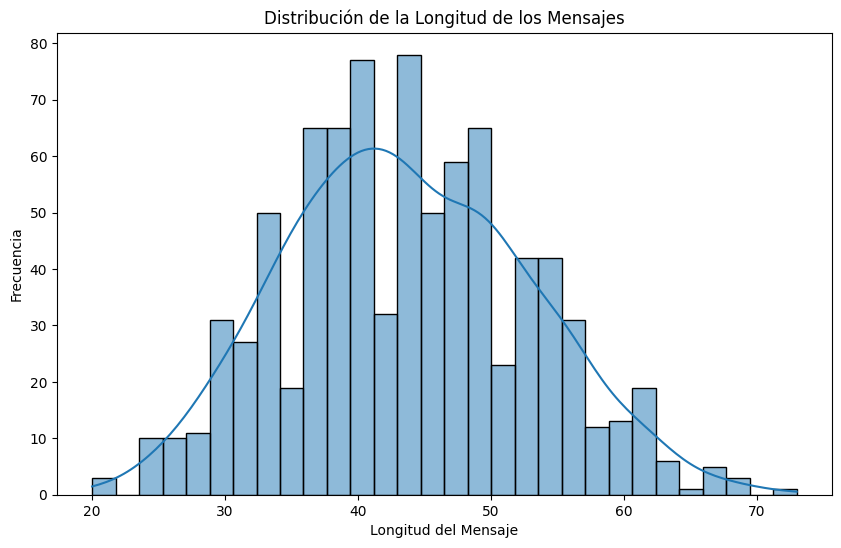

In [12]:
# Añadir una nueva columna con la longitud de cada mensaje
train_df_sin_duplicados['longitud'] = train_df_sin_duplicados['mensaje'].apply(len)

# Mostrar las estadísticas de la longitud de los mensajes
print(train_df_sin_duplicados['longitud'].describe())

# Visualización de la longitud de los mensajes
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(train_df_sin_duplicados['longitud'], bins=30, kde=True)
plt.title('Distribución de la Longitud de los Mensajes')
plt.xlabel('Longitud del Mensaje')
plt.ylabel('Frecuencia')
plt.show()


 la interpretación de los estadísticos:

count: Indica que ahora hay 850 observaciones (filas) únicas en la columna longitud, después de eliminar los duplicados.

mean: La longitud promedio de los valores únicos en la columna longitud es aproximadamente 43.67.

std: La desviación estándar de los valores en la columna longitud es aproximadamente 9.16, lo cual indica la dispersión de los datos alrededor de la media en los mensajes únicos.

min: El valor mínimo en la columna longitud sigue siendo 20.

25%: El primer cuartil (percentil 25) de la distribución de la longitud es 37. Esto significa que el 25% de los valores de longitud únicos son menores o iguales a 37.

50% (median): La mediana de la longitud es 43, lo que indica que el 50% de los valores de longitud únicos son menores o iguales a 43.

75%: El tercer cuartil (percentil 75) de la distribución de la longitud es 50. Esto significa que el 75% de los valores de longitud únicos son menores o iguales a 50.

max: El valor máximo en la columna longitud sigue siendo 73.

Continuemos con el análisis de palabras más frecuentes y la visualización de nubes de palabras.

4.2 Palabras más frecuentes en mensajes "spam" y "ham"

In [13]:
# Importar librerías necesarias para el análisis de texto
from collections import Counter
import re
from wordcloud import WordCloud

# Función para limpiar el texto
def limpiar_texto(texto):
    texto = re.sub(r'\W', ' ', texto) # Eliminar caracteres no alfanuméricos
    texto = texto.lower() # Convertir a minúsculas
    texto = re.sub(r'\s+', ' ', texto) # Eliminar espacios extra
    return texto

# Limpiar los mensajes
train_df_sin_duplicados['mensaje_limpio'] = train_df_sin_duplicados['mensaje'].apply(limpiar_texto)

# Separar mensajes "spam" y "ham"
spam_text = ' '.join(train_df_sin_duplicados[train_df_sin_duplicados['tipo'] == 'spam']['mensaje_limpio'])
ham_text = ' '.join(train_df_sin_duplicados[train_df_sin_duplicados['tipo'] == 'ham']['mensaje_limpio'])

# Contar palabras más comunes
spam_palabras = Counter(spam_text.split())
ham_palabras = Counter(ham_text.split())

print("Palabras más comunes en mensajes 'spam':")
print(spam_palabras.most_common(10))

print("\nPalabras más comunes en mensajes 'ham':")
print(ham_palabras.most_common(10))


Palabras más comunes en mensajes 'spam':
[('de', 156), ('tu', 150), ('con', 127), ('nuestro', 79), ('este', 72), ('en', 72), ('para', 57), ('un', 56), ('gana', 49), ('a', 45)]

Palabras más comunes en mensajes 'ham':
[('tu', 253), ('de', 116), ('por', 103), ('a', 55), ('gracias', 54), ('en', 44), ('sido', 39), ('un', 38), ('favor', 38), ('está', 37)]


In [14]:
print("Palabras más comunes en mensajes 'spam':")
print(spam_palabras.most_common(30))

print("\nPalabras más comunes en mensajes 'ham':")
print(ham_palabras.most_common(30))

Palabras más comunes en mensajes 'spam':
[('de', 156), ('tu', 150), ('con', 127), ('nuestro', 79), ('este', 72), ('en', 72), ('para', 57), ('un', 56), ('gana', 49), ('a', 45), ('y', 42), ('tus', 32), ('gratis', 28), ('clic', 26), ('una', 26), ('haz', 25), ('el', 25), ('por', 23), ('la', 23), ('esta', 21), ('nuestra', 21), ('te', 20), ('obtén', 20), ('nuestras', 19), ('necesitamos', 17), ('dinero', 16), ('obten', 16), ('no', 15), ('nuestros', 15), ('invierte', 14)]

Palabras más comunes en mensajes 'ham':
[('tu', 253), ('de', 116), ('por', 103), ('a', 55), ('gracias', 54), ('en', 44), ('sido', 39), ('un', 38), ('favor', 38), ('está', 37), ('ha', 36), ('y', 35), ('tus', 35), ('que', 31), ('con', 30), ('hola', 30), ('te', 30), ('el', 29), ('la', 28), ('nuestro', 27), ('para', 26), ('este', 24), ('es', 21), ('cita', 18), ('una', 16), ('recordatorio', 15), ('pago', 15), ('aquí', 15), ('cuenta', 14), ('confirma', 13)]


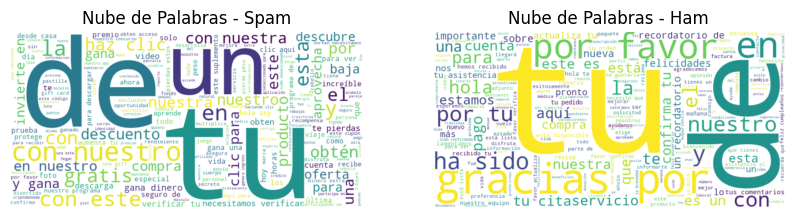

In [15]:
# Generar nubes de palabras
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

# Mostrar nubes de palabras
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Spam')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Ham')

plt.show()


1. Filtrado de palabras vacías (stopwords)
Las palabras vacías son palabras comunes que generalmente no aportan un significado relevante al análisis de texto, como artículos, preposiciones y conjunciones. Es importante filtrar estas palabras para centrarte en las palabras que podrían ser más informativas sobre el contenido de los mensajes 'spam' y 'ham'.

Primero, vamos a definir una lista de palabras vacías en español. Utilizaremos la lista proporcionada por nltk, una biblioteca popular para procesamiento de texto en Python.

In [16]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords_sp = stopwords.words('spanish')

# Agregar palabras adicionales que no aporten significado en este contexto específico
stopwords_sp.extend(['este', 'nuestro', 'con', 'para', 'esta'])  # Podemos ajustar esta lista según necesitemos

# Función para limpiar el texto y filtrar stopwords
def limpiar_texto_con_stopwords(texto):
    texto = re.sub(r'\W', ' ', texto) # Eliminar caracteres no alfanuméricos
    texto = texto.lower() # Convertir a minúsculas
    texto = re.sub(r'\s+', ' ', texto) # Eliminar espacios extra
    palabras = texto.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stopwords_sp]
    return ' '.join(palabras_filtradas)

# Aplicar limpieza con filtro de stopwords a los mensajes
train_df_sin_duplicados['mensaje_limpio_stopwords'] = train_df_sin_duplicados['mensaje'].apply(limpiar_texto_con_stopwords)

# Mostrar los mensajes limpios con filtrado de stopwords
print(train_df_sin_duplicados[['mensaje', 'mensaje_limpio_stopwords']].head(10))


                                           mensaje  \
0      Compra ahora y recibe un descuento especial   
1               Haz clic aqui para ganar un premio   
2                      Tu ordenador tiene un virus   
3            Descubre como perder peso rapidamente   
4                     Necesitas ayuda con tu tarea   
5              Gana dinero desde casa sin esfuerzo   
6        Reclama tu herencia de un pariente lejano   
7   Mejora tu rendimiento sexual con este producto   
8               Por favor responde a esta encuesta   
9  Invierte en esta oportunidad unica y hazte rico   

                 mensaje_limpio_stopwords  
0  compra ahora recibe descuento especial  
1              haz clic aqui ganar premio  
2                         ordenador virus  
3        descubre perder peso rapidamente  
4                   necesitas ayuda tarea  
5               gana dinero casa esfuerzo  
6        reclama herencia pariente lejano  
7      mejora rendimiento sexual producto  
8        

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Vectorización de los mensajes limpios
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_df_sin_duplicados['mensaje_limpio_stopwords'])
y = train_df_sin_duplicados['tipo'].apply(lambda x: 1 if x == 'spam' else 0)

# Inicialización y entrenamiento del modelo Naive Bayes con todos los datos
model = MultinomialNB()
model.fit(X, y)

# Guardar el modelo entrenado
with open('../modelos_y_vectorizadores/modelo_naive_bayes_entrenado_completo.pkl', 'wb') as archivo:
    pickle.dump(model, archivo)


In [18]:
import joblib

# Guardar el vectorizador en un archivo .pkl
joblib.dump(vectorizer, '../modelos_y_vectorizadores/vectorizador.pkl')


['vectorizador.pkl']